In the real world,fraud often goes undiscovered,an only the fraud that is caught provides any labels for the dataset.Moreover,fraud patterns change over time,so supervised systems that are built using fraud labels become stale,capturing historical patterns of fraud but failing to adapt to newly emerging patterns.For these reasons unsupervised learning fraud detection systems are in vogue..

#Anamoly detection -- Creditcard fraud detection..
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Time: Number of seconds elapsed between this transaction and the first transaction in the dataset
V1 may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28abc
AmountTransaction amount
Class1 for fraudulent transactions, 0 otherwise

In [1]:
#Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os,time
import pickle,gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Preparation and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics import roc_curve,auc,roc_auc_score

In [2]:
#Load dataset
current_path = os.getcwd()
file = '\\creditcard.csv'
data = pd.read_csv(current_path+file)

dataX = data.copy().drop(['Class'],axis = 1)
dataY = data['Class'].copy()

featureToScale = dataX.columns
sX = pp.StandardScaler(copy = True)
dataX.loc[:,featureToScale] = sX.fit_transform(dataX[featureToScale])

X_train,X_test,y_train,y_test = \
          train_test_split(dataX,dataY,test_size = 0.33,\
                          random_state = 2018,stratify = dataY)

#Define anomaly score function:
We will define a function that calculates how anomalous each transaction is,the more anomalous the transaction is,the more likely it is to be fraudulent,assuming that the fraud is rare and looks somewhat different than the majority of transactions,which are normal.

In [3]:
def anomalyScores(originalDf,reducedDf):
    loss = np.sum((np.array(originalDf)-np.array(reducedDf))**2,axis=1)
    loss = pd.Series(data = loss,index = originalDf.index)
    loss = (loss - np.min(loss))/(np.max(loss)-np.min(loss))
    return loss
#reconstruction error for each transaction is the sum of the 
#squared differences b/w the original feature matrix and the reconstructed
#matrix using the dimensionality reduction.

In [24]:
#Define evaluation metrics
#we will use the labels to evaluate the unsupervised solutions we deve;op
#which will help us to understand we will be using precision-recall curve
#average precision

def plotResults(truelabels,anomalyScores,returnPreds = False):
    preds = pd.concat([truelabels,anomalyScores],axis = 1)
    preds.columns = ['trueLabel','anomalyScore']
    precision,recall,thresholds = \
              precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
             average_precision_score(preds['trueLabel'],preds['anomalyScore'])
   
    plt.step(recall,precision,color = 'k',alpha = 0.7,where = 'post')
    plt.fill_between(recall,precision,step = 'post',alpha = 0.3,color = 'k')
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    
    plt.title("Precision-recall-Curve:Average Precision = \
              {0:0.2f}".format(average_precision))
    
    fpr,tpr,thresholds = roc_curve(preds['trueLabel'],preds['anomalyScore'])
    areaUnderROC = auc(fpr,tpr)
    
    plt.figure()
    plt.plot(fpr,tpr,color = 'r',lw = 2,label='ROC Curve')
    plt.plot([0,1],[0,1],color = 'k',lw = 2,linestyle = '--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC:Area Under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc = 'best')
    plt.show()
    
    if returnPreds == True:
        return preds  

In [25]:
#define plotting function
#we will use scatter plot to display the separation of points.
def scatterPlot(xDF,yDF,algoName):
    tempDF = pd.DataFrame(data = xDF.loc[:,0:1],index = xDF.index)
    tempDF = pd.concat((tempDF,yDF),axis=1,join = 'inner')
    tempDF.columns = ["First Vector","Second Vector","Label"]
    sns.lmplot(x = 'First Vector',y='Second Vector',hue = 'Label',\
              data = tempDF,fit_reg = False)
    ax = plt.gca()
    ax.set_title("Separation of Observations"+algoName)

Remember that the features of the dataset are alredy the ouTput of PCA-which is what givem by the financial company 

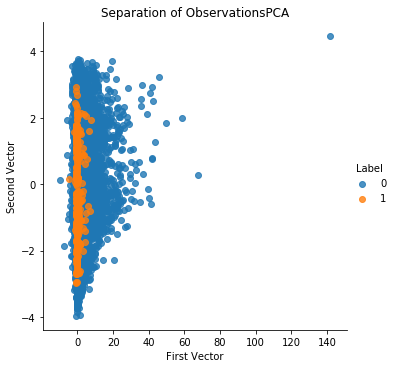

In [26]:
#PCA
#30 components 
from sklearn.decomposition import PCA
n_components = 30
whiten = False
random_state = 2018
pca = PCA(n_components = n_components,whiten = whiten,\
         random_state = random_state)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA,index = X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse,index = X_train.index)

scatterPlot(X_train_PCA,y_train,"PCA")

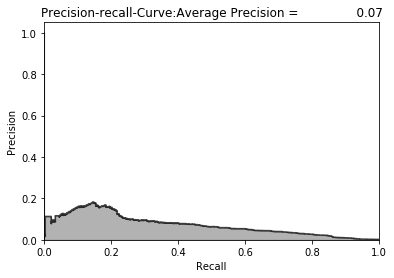

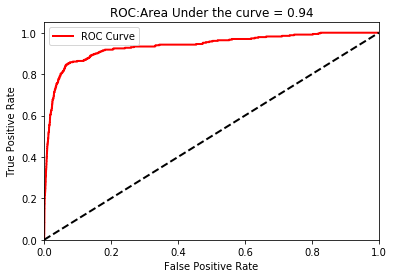

In [27]:
anamolyscoresPCA = anomalyScores(X_train,X_train_PCA_inverse)
preds = plotResults(y_train,anamolyscoresPCA,True)

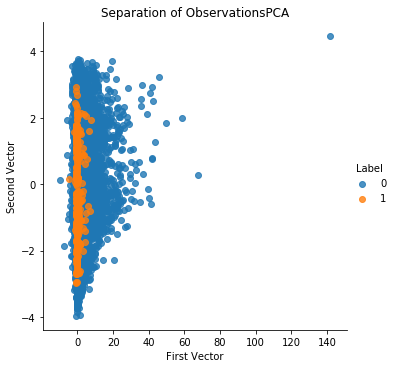

In [28]:
#PCA
#27 components 
from sklearn.decomposition import PCA
n_components = 27
whiten = False
random_state = 2018
pca = PCA(n_components = n_components,whiten = whiten,\
         random_state = random_state)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA,index = X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse,index = X_train.index)

scatterPlot(X_train_PCA,y_train,"PCA")

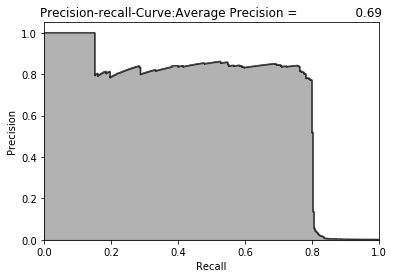

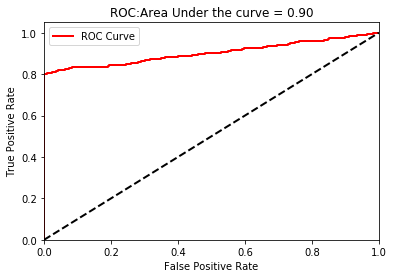

In [29]:
anamolyscoresPCA = anomalyScores(X_train,X_train_PCA_inverse)
preds = plotResults(y_train,anamolyscoresPCA,True)

In [30]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.75
Recall:  0.8
Fraud Caught out of 330 Cases: 264
